## VISCNN API DEMO

Before we begin, specify if you're using a machine with gpu's or not;

In [20]:
device = 'cuda:0'
#device = 'cpu'

### Model "Dissection"
 
VISCNN is a tool concerned with intermediary processing steps implemented by CNNs. One important intermediary that is often hidden in deep learning library's is the activation maps output by individual 2D kernels. Under normal circumstances, a convolutional layer has 'input' channels and 'output' channels. in pytorch, such a layer looks something like this;

In [11]:
import torch
from torch import nn


conv_layer = torch.nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3)
conv_layer

Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))


We can pass 3 input maps (here our input 'maps' will be 6x6 arrays) into 'conv_layer' and it will produce 5 output maps;


In [12]:
input_maps = torch.rand(1,3,6,6) # we use '1' as our first dimension, 
                                   # as normally pytorch assumes we are operating on some 'batch' of multiple images
output_maps = conv_layer(input_maps)
output_maps.shape

torch.Size([1, 5, 4, 4])

These input and output maps don't show us the whole story, there are intermediary activation maps produced inside 
these conv layers. These hidden maps are produced by apply a single convolution kernel, before getting added together pointwise to generate an output channel activation map. With VISCNN, we can 'dissect' convolutional layers to get access to the full computational process;

In [13]:
from viscnn.dissected_Conv2d import dissected_Conv2d


dissected_conv_layer = dissected_Conv2d(conv_layer)
dissected_conv_layer

dissected_Conv2d(
  (preadd_conv): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), groups=3, bias=False)
)


Dissected Conv modules perform the same operations as the original conv;


In [14]:
output_maps_2 = dissected_conv_layer(input_maps)

torch.isclose(output_maps_2,output_maps) #output_maps is what was outputted by the original conv_layer

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]]]])

We can set up our dissected conv to store intermediary values within the module

In [19]:
dissected_conv_layer = dissected_Conv2d(conv_layer,store_activations=True)
output_maps_2 = dissected_conv_layer(input_maps)

print('pre pointwise added activation maps')
print(dissected_conv_layer.preadd_out.shape) #all output activation maps, before point-wise summing into output channels
print('\n')

print('pre pointwise added activation maps sorted by out channels')
print(dissected_conv_layer.format_edges().shape) ##fetch preadd activations as [img,out_channel, in_channel,h,w]
print('\n')

print('final output activation maps')
print(dissected_conv_layer.postbias_out.shape) #normal activation maps outputted by conv_2d after summing and adding bias
print('\n')


pre pointwise added activation maps
torch.Size([1, 15, 4, 4])


pre pointwise added activation maps sorted by out channels
(1, 5, 3, 4, 4)


final output activation maps
torch.Size([1, 5, 4, 4])




We can also 'dissect' any entire convolutional neural network, iterating through its modules and separating each instance of 'Conv2d' with 'dissected_Conv2d';

In [36]:
from torchvision.models import alexnet
from viscnn.dissected_Conv2d import dissect_model
from copy import deepcopy  #well dissect the model on a copy of the original model, 
                           #as or dissector function dissects the model in place

    
model = alexnet(pretrained=True)
_ = model.to(device).eval()

dissected_model = dissect_model(deepcopy(model), device=device)

print('original model modules:')
print(model)

print('dissected model modules:')
print(dissected_model)

original model modules:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_fea

### feature visualization (with lucent)

For feature visualizations VISCNN uses the Lucent library, so we'll just demo their API here. For a more thorough demonstration of the power of lucent, check out the demos on their github (https://github.com/greentfrapp/lucent)

First we get a naming scheme, according to lucent, that we can use to reference the layers we want to visualize

In [24]:
from lucent.modelzoo.util import get_model_layers

get_model_layers(model)



['features',
 'features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

We can visualize quickly by just referencing a model, the layer name, and a numerical index of the feature

  2%|▏         | 9/512 [00:00<00:05, 84.53it/s]

layer 0, 10th feature


100%|██████████| 512/512 [00:04<00:00, 103.04it/s]



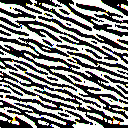

  2%|▏         | 9/512 [00:00<00:05, 83.90it/s]

layer 8, 146th feature


100%|██████████| 512/512 [00:05<00:00, 87.33it/s]



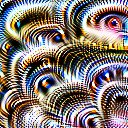

  2%|▏         | 8/512 [00:00<00:07, 71.19it/s]

classification layer, 7th category (rooster)


100%|██████████| 512/512 [00:06<00:00, 80.11it/s]



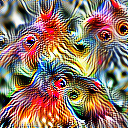

In [42]:
from lucent.optvis import render, param, transform, objectives


print('layer 0, 10th feature')
_ = render.render_vis(model, "features_0:10", show_inline=True)

print('layer 8, 146th feature')
_ = render.render_vis(model, "features_8:146", show_inline=True)

print('classification layer, 7th category (rooster)')
_ = render.render_vis(model, "classifier_6:7", show_inline=True)

Above we defaulted to a 'channel-wise' objective, which means 'generate an image that makes the sum over an entire feature-map high'. We could also use a 'neuron-wise' objective, which means 'generate an image which makes the central activation in the feature map high'.

100%|██████████| 512/512 [00:05<00:00, 100.23it/s]



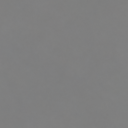

In [44]:
obj  = objectives.neuron('features_0',0)

_ = render.render_vis(model, obj, show_inline=True)

In [ ]:
channel = lambda n: objectives.channel("mixed4a", n)
obj = channel(476) + channel(465)
_ = render.render_vis(model, obj, show_inline=True)

## Model Prep

ModuleAttributeError: 'Conv2d' object has no attribute 'name'